# Landmark Classification & Tagging for Social Media

**Data**: [download data directly](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip)

In this project, I applied the skills I have acquired in the Convolutional Neural Network (CNN) module to build a landmark classifier at Udacity Deep Learning Nanodegree.

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

**Example output**:

<img src="src/example.png">

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# import packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torchsummary import summary

import torch
from torch import nn, optim, functional as F
from torchvision import models

import utils

sns.set()
%matplotlib inline

# Pure PyTorch implementation

## Visualize dataset

In [3]:
batch_size = 24
train_path = 'data/train'
test_path  = 'data/test'

# create loaders
train_loader, val_loader, test_loader, dataset = utils.create_loaders(batch_size, train_path, test_path, own=True)
loaders = dict(train=train_loader, val=val_loader, test=test_loader)

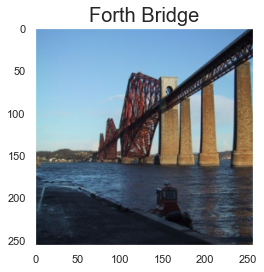

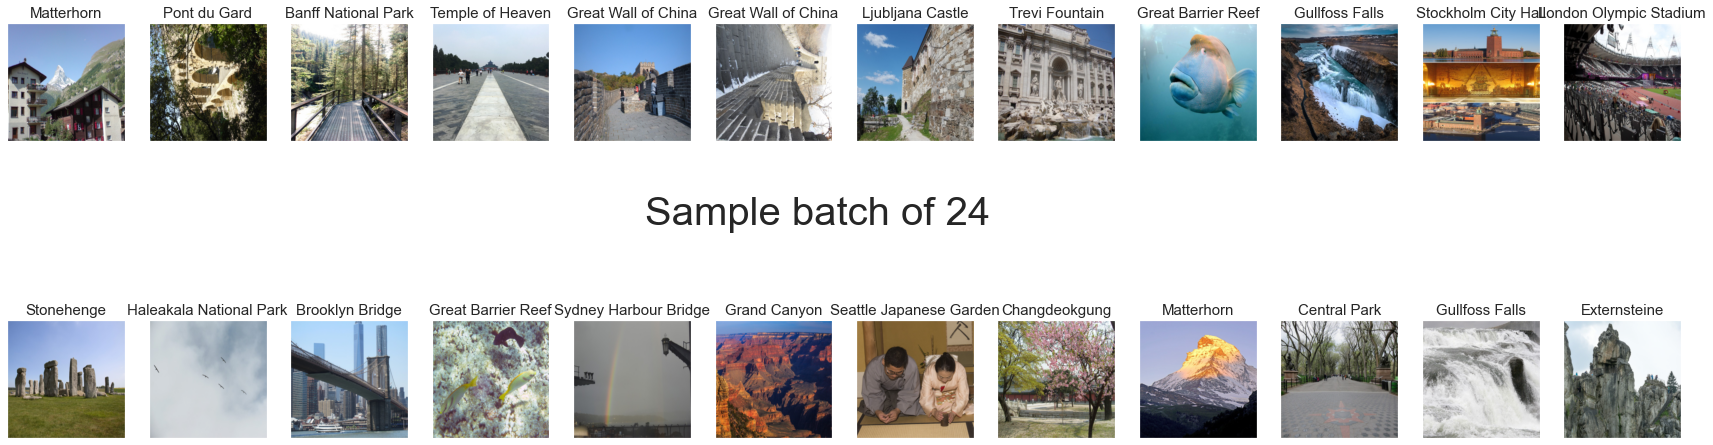

In [4]:
# show first N image locations
dictionary = utils.Dictionary(dataset)

utils.visualize(test_loader, dictionary, single=True)
utils.visualize(test_loader, dictionary)

In [5]:
# get information on gpu 
use_cuda = torch.cuda.is_available()
use_cuda

True

In [6]:
model = models.resnet34(pretrained=True)

In [7]:
# freeze parameters
for param in model.parameters():
    param.requires_grad = False

# change last layer
model.fc = nn.Linear(model.fc.in_features, 50)
print(model.fc)

Linear(in_features=512, out_features=50, bias=True)


In [8]:
if use_cuda:
    model = model.cuda()

In [9]:
# check model architecture
summary(model, (3, 224, 224))

C:\Users\dinar\miniconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [10]:
def train(n_epochs:int, loaders:dict, model, optimizer, criterion, use_cuda:bool,
          save_path:str, learning_decay_scheduler):
    """
    This function trains the model and shows the progress.

    Parameters:
        n_epochs (int): Number of epochs to train for
        loaders (dict): Dictionary of loaders to use
        model: Model being used
        optimizer: Selected optimizer
        criterion: Loss function
        use_cuda (bool): If GPU is enables or not
        save_path (str): Path to store the results in
        learning_decay_scheduler: Learning rate decay scheduler to use

    Returns:
        A trained model
    """
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # record the average training loss, using something like
            optimizer.zero_grad()
            
            # get the final outputs
            output = model(data)
            
            # calculate the loss
            loss = criterion(output, target)
            
            # start back propagation
            loss.backward()
            
            # update the weights
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['val']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
        
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(val_loader.sampler)
        
        # print training/validation statistics every 5 epochs
        if epoch % 5 == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

        ## if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        # update learning rate decay
        learning_decay_scheduler.step()
            
    return model, train_loss, valid_loss

In [11]:
def test(loaders, model, criterion, use_cuda):
    """
    This functions calculates the correctness and shows the results of the architecture.

    Parameters:
        loaders: Dictionary that stores all three loaders
        model: Model used for implementation
        criterion: Loss function
        use_cuda: If GPU is available or not

    Returns:
        The accuracy of the model
    """
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    # show the accuracy
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [12]:
# get optimizer

def get_optimizer(model):
    """
    This function creates the optimizer and its learning rate decay scheduler.

    Parameters:
        model: Model to use
    """
    
    # initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    
    # initialize learning decay scheduler
    lr_decay = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)
    
    return optimizer, lr_decay

# get optimizer & lr decay scheduler
optimizer, lr_decay = get_optimizer(model)

In [13]:
%%time
criterion = nn.CrossEntropyLoss()
resnet34_model, resnet34_train_loss, resnet34_val_loss = train(30, loaders, model, optimizer, criterion, use_cuda, 'resnet34.pt', lr_decay)


Validation loss decreased (inf --> 1.916838).  Saving model ...
Validation loss decreased (1.916838 --> 1.840856).  Saving model ...
Epoch: 5 	Training Loss: 1.289807 	Validation Loss: 2.082224
Epoch: 10 	Training Loss: 0.981798 	Validation Loss: 2.189808
Epoch: 15 	Training Loss: 0.739280 	Validation Loss: 2.201154
Epoch: 20 	Training Loss: 0.592738 	Validation Loss: 2.168530
Epoch: 25 	Training Loss: 0.477049 	Validation Loss: 2.191907
Epoch: 30 	Training Loss: 0.411420 	Validation Loss: 1.983963
CPU times: total: 1h 11min 40s
Wall time: 36min 23s


In [14]:
# load the model that got the best validation accuracy
test(loaders, resnet34_model, criterion, use_cuda)

Test Loss: 1.616707


Test Accuracy: 73% (920/1250)


In [31]:
import cv2
from PIL import Image
from torch.nn import functional as F

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path:str, k:int, model):
    """
    This function read the image file, applies appropriate transformations, predicts top K locations of images.

    Parameters:
         img_path (str): Path to an image
         k (int): Top locations to show

    Returns:
        transformed image and pretty formatted location predictions
    """
    # transform the image
    img = utils.create_loaders(0, img_path=img_path, single=True)

    # pass the model in evaluation mode
    model.eval()
    # get predictions
    output = model(img)
    # apply softmax to get probabilities
    output = F.softmax(output, dim=1)
    # show top K location predictions
    topk = torch.topk(output, k)

    return img, dictionary.get_content(topk[1].detach().cpu().numpy()[0]), topk[0].detach().cpu().numpy()[0]

# test on a sample image
_, output, probs = predict_landmarks('data/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5, resnet34_model)
output, probs


('Golden Gate Bridge, Brooklyn Bridge, Dead Sea, Forth Bridge, Niagara Falls',
 array([9.99989748e-01, 1.00902071e-05, 1.05093896e-07, 9.92599780e-08,
        2.22159580e-09], dtype=float32))

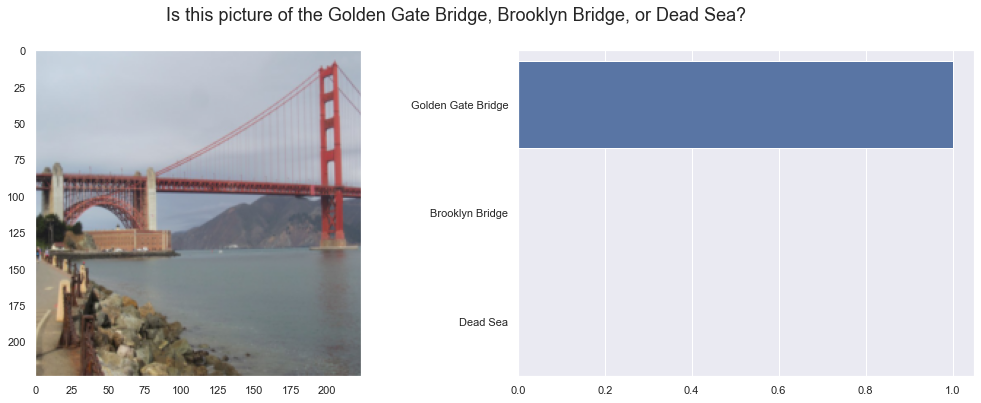

In [38]:
from torchvision import transforms

def suggest_locations(img_path: str, model):
    """
    This function shows the final image and associated K predictions.

    Parameters:
        img_path (str): Path to an image
    """
    # get landmark predictions
    img, predicted_landmarks, probs = predict_landmarks(img_path, 3, model)
    s, m = torch.Tensor([0.229, 0.224, 0.225]), torch.Tensor([0.485, 0.456, 0.406])
    unnormalize = transforms.Normalize((-m / s).tolist(), (1.0 / s).tolist())


    # create pretty output depending on K [1, 5] locations
    text = 'Is this picture of the '
    # show prediction for one location
    if not predicted_landmarks.find(','):
        text = predicted_landmarks + '?'
    else:
        # show prediction for two locations
        landmarks = predicted_landmarks.split(', ')
        if len(landmarks) == 2:
            text += landmarks[0] + ' or ' + landmarks[1] + '?'
        else:
            # show prediction for more than two locations
            text += ', '.join(landmarks[:-1]) + ', or ' + landmarks[-1] + '?'
    # normalize the image and show the predictions
    convert = lambda x: np.clip(unnormalize(x).cpu().numpy().transpose((1, 2, 0)), 0, 1)
    image = convert(img[0, :])
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(text, size=18)
    ax[0].grid(None)
    ax[0].imshow(image)
    
    sns.barplot(x=probs, y=predicted_landmarks.split(','), color=sns.color_palette()[0], ax=ax[1])
    plt.show()

# test on a sample image
suggest_locations('data/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', resnet34_model)